# Pokémon Type Identifier
By Nicholas Levin, Justin Levine, Jarod French, and Anthony Louie

In [7]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from seaborn import heatmap

import os, random
from PIL import Image
from IPython.display import Image as show_img, display
import PIL
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import csv
import math

## Introduction

Pokémon is a massive franchise, having over 440 million copies sold worldwide as of March 2022, in addition to TV shows, trading cards, and other merchandise. Currently, there are a total of 1008 Pokémon over 9 different generations.

Each Pokémon has one or two "types," of which there are 18 total of. The types are: Normal, Fire, Water, Grass, Electric, Ice, Fighting, Poison, Ground, Flying, Psychic, Bug, Rock, Ghost, Dark, Dragon, Steel, and Fairy. This types determine the Pokémon's strengths and weaknesses in battles. Additionally, and this is what we explore in this project, these types influence the Pokémon's appearence, and each type usually has some sort of archetype. To demonstrate how type can influence appearence, here are some examples of Fire type Pokémon.

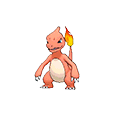 

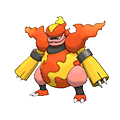

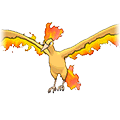

As you can see, Fire-type Pokémon are commonly marked by their warm color pallets, often featuring shades of red, orange, and yellow, as well as flames visible from their bodies. In this way, the other 17 types also have their defining archetypes that sets them apart from the other types. If you'd like to learn more about Pokémon types, as well as how those types influence each Pokémon, you can read more about them [here](https://pokemon.fandom.com/wiki/Types).

## Motivation

Although there are a fairly limited amount of Pokémon, there is a fairly clear correlation between how the Pokémon looks, and its typing. We wanted to test whether or not we could build a Machine Learning model that would be able to learn these typings, and then be able to make accurate predictions on new Pokémon. This has applications in a few areas. Firstly, many Pokémon are leaked before they are officially released, meaning a picture or screenshot will be posted on the Internet without any details such as type and name. This model could hopefully assign those images a type, to help us learn more about them.

Additionally, a type-classification model could help for organization purposes. Many Pokémon have associated stuffed animals that are sold in stores, but they don't come with information such as type. This could make it difficult for a store employee or someone who didn't know much of anything about Pokémon to organize the stuffed animals in a meaningful way on store shelves.

## Data Collection

We collected data using Kaggle, as well as scraping the web. Kaggle is a website with a large number of datasets available to the public that are mostly used for data science and machine learning projects. There are also many Pokémon datasets, but we chose 2 datasets that cover most of the Pokémon that exist. We are using The Complete Pokémon Images [Dataset](https://www.kaggle.com/datasets/arenagrenade/the-complete-pokemon-images-data-set) and the Pokémon Gen 1-8 [Dataset](https://www.kaggle.com/datasets/notlucasp/pokemon-gen-18-dataset?resource=download&select=pokemons.csv). 

Now, there are 9 generations as mentioned above, and our datasets only cover generations 1-8 since generation 9 has just recently come out. So we had to do a little bit of web scraping. To do this we use the requests, bs4, and csv libraries to gather and format the html to get the new Pokémons names types and images.

In [11]:
url = 'https://pokemondb.net/pokedex/game/scarlet-violet'

# Request the html from the url using the requests library
page = requests.get(url='https://pokemondb.net/pokedex/game/scarlet-violet')

# Use Beautiful Soup from bs4 to parse the html and make it more readable 
soup = BeautifulSoup(page.text, 'html.parser')
soup.prettify()

# Usually you might want to stop before this step to look at the html and 
# figure out what data you need from the html; not every website is the same
# Here we need the data in the 'span' sections of the html
soup_imgs = soup.findAll('span')
soup_text = soup.findAll('span')[9::2]

# Get all the text for each Pokémon in a list  
text_list = []

for item in soup_text:
    s = item.text.split(' ')
    text_list.append(s)

# Get only the data we need from each text block 
pokemon = []
for list in text_list:
    # Here we have some Pokémon whose names have 2 words in them,
    # so we have to adjust our appendings accordingly
    if int(list[0].replace('#','')) < 376:
        if len(list) > 3:
            pokemon.append(list[1]+','+list[2]+','+list[4])
        else:
            pokemon.append(list[1]+','+list[2])
    else:
        if len(list) > 5:
            pokemon.append(list[1]+' '+list[2]+','+list[3]+','+list[5])
        elif len(list) > 4:
            pokemon.append(list[1]+','+list[2]+','+list[4])
        else:
            pokemon.append(list[1]+','+list[2])

# Now we have just the Pokémon's name and its type to put in a new list
pokemon_list = []
for list in pokemon:
    pokemon_list.append(str(list).split(','))
    
print("This is the first 11 Pokémon in the list:")
print(pokemon_list[:10])

This is the first 11 Pokémon in the list:
[['Sprigatito', 'Grass'], ['Floragato', 'Grass'], ['Meowscarada', 'Grass', 'Dark'], ['Fuecoco', 'Fire'], ['Crocalor', 'Fire'], ['Skeledirge', 'Fire', 'Ghost'], ['Quaxly', 'Water'], ['Quaxwell', 'Water'], ['Quaquaval', 'Water', 'Fighting'], ['Lechonk', 'Normal']]


Now we have each new Pokémon and its type, so we can cross reference with the csv we got from kaggle to add only new Pokémon, not the Pokémon that are repeated in the new generation.

In [ ]:
# Read the old csv
pm = pd.read_csv('pokemons.csv')

# Drop all columns we will not be using
pm = pm.drop(['NationalNumber','Normal',"Fire","Water","Electric","Grass","Fighting","Poison","Bug","Ice","Ground","Flying","Psychic","Rock","Ghost","Dragon","Dark","Steel","Fairy"],axis=1)

# Make a list of only new Pokémon from our other list
to_add = []
for pokemon in pokemon_list:
    if pokemon[0] not in pm['Pokemon'].values:
        to_add.append(pokemon)

for lst in to_add:
    if len(lst) < 3:
        lst.append('NaN')

# Add each Pokémon to the dataframe
for i in range(0,len(to_add)):
    pm.loc[894+i] = to_add[i]

# replace any NaN strings with actuall NaN
for row in pm:
    for val in row:
        if val =="NaN":
            pm[row[val]] = math.isnan(float(val))

# Write the dataframe to a new csv
pm.to_csv('./Pokemon_to_gen_9.csv')

Now we have all the Pokémon in our csv so the next step is to get the image urls from the html:

In [ ]:
# Find all images in the html, the first image is the website header in 
# this case so we skip that one
soup_imgs = soup.findAll('img')[1:]

# Get a list of tuples of the html containing the Pokémon names and urls for each Pokémon
images = []
for i in range(0,len(soup_imgs)):
    soup_imgs[i] = str(soup_imgs[i]).split(' ')
    if len(soup_imgs[i]) == 7: # Pokémon has 2 word name
        images.append([soup_imgs[i][1]+" "+soup_imgs[i][2],soup_imgs[i][6]])
    else: # one word name
        images.append([soup_imgs[i][1],soup_imgs[i][5]])

# Break that list into names and urls that correlate by index and get only the names and urls
names = []
urls = []
for i in range(0, len(images)):
    names.append(images[i][0].replace("alt=\"", '').replace("\"", ''))
    urls.append(images[i][1].replace('src=\"', '').replace("\"/>",''))

# Make the list of Pokémon names and images to be added since we already have the 
# Pokémon from previous generations (i.e. take out the repeated Pokémon)
images1 = []
# 376-387, 397,398 => indexes 375-386,396,397 have 2 word names
for i in range(0,len(names)): 
    if names[i] not in pm['Pokemon'].values:
        if i > 374 and i < 387:
            images1.append([names[i], urls[i]])
        else:
            images1.append([names[i], urls[i]])

Now we have a list of images and Names for each Pokémon, we want to save them all to the same folder as the other dataset. This [article](https://understandingdata.com/python-for-seo/how-to-download-images-in-python/) shows exactly how to save a list of images when you have the url for each, and here is how we did it.

In [ ]:
# List to catch and keep track of any image urls that don't work 
broken_images = []
for img in images1:
    # directory to save images into
    directory = './images1/'
    # if there is a space in the name to be saved
    file_name = img[0].replace(' ','-') + '.png'
    file_path = directory+file_name
    # img[1] is the url of the image
    r = requests.get(img[1], stream=True)
    # status code 200 indicates a successful request
    if r.status_code == 200:
        with open(file_path, 'wb') as f:
            for chunk in r:
                f.write(chunk)
    else:
        broken_images.append(img)

Now we have our csv of all the Pokémon and images for each Pokémon to use as input.

## Convolutional Neural Network

Since our data is in the form of images, the best way to learn patterns from those images is to use a Convolutional Neural Network (CNN). These Neural Networks work by applying convolutions, or filters that learn from parts of the image, multiple times in order to extract the most important and defining features of that image. These convolutions are followed my poolings, which help decrease the size of the convolved feature. If you'd like to learn more about the fine details about how CNNs work, [this article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) is a good resource to do so.

### Preprocessing the Data

With the images from all Pokémon generations 1-9 collected, we first read the Pokémon names and types into a Pandas dataframe sorted by Pokémon name for easy access.

In [7]:
# Load dataframe from csv
df = pd.read_csv("Pokemon_to_gen_9.csv")
df = df.sort_values(by="Pokemon")

Next, we have to get the array of images. Our image array should be of shape (1008, 120, 120, 3), since there are 1008 examples, and each image will be represented as a 120 x 120 x 3 array, where 120 x 120 is the height and width of each image. To do this, we use numpy and the Image library in Python.

In [8]:
# Load images
# TODO: Integrate the gen 8 and 9 dataset
images = np.zeros((df.shape[0], 120, 120, 3), dtype=np.uint8) # If you change the datatype, it gets messed up
index = 0
for image in os.listdir("data\\images_with_gen_9"):
    img = Image.open("data\\images_with_gen_9\\" + image)
    newimg = Image.new('RGB', img.size, (255, 255, 255))
    newimg.paste(img, None)
    newimg.thumbnail((120, 120))
    data = np.asarray(newimg)
    images[index] = data
    index += 1

c:\Users\justi\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Now that we have our images and types, there are a few more steps of processing we must do on the data before we plug it into our model. Firstly, we have to convert our types to their One-Hot Encoding representation. This is a way of turning categorical data (our types in this case) into an array of binary values for our model to train more easily on. You can read more about why we using One-Hot Encoding [here](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

In [19]:
labels = df["Type_1"].to_numpy().reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(labels)

Finally, we must split our data into training data, and test data. Our training data will be what the model trains on, and then the test data will ensure that the model is properly generalizing to new examples well.

We also divide the pixel values by 255 to normalize our values between 0 and 1.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, onehot_encoded, test_size=0.2)
X_train = X_train / 255.0
X_test = X_test / 255.0

### Constructing the Model

To build the model, we use the Python library tensorflow. The pattern that is used to build CNNs are Conv2D (convolution) layers, followed by MaxPooling2D layers to pool the data. We also use Dropout layers intermittently, which is a good technique to help prevent the model from overfitting to the data.

The activation function we use for our models is ReLU, or the Rectified Linear Unit function. This is a very common activation function for many Neural Networks.

In [11]:
model = models.Sequential()

model.add(layers.Conv2D(128, (6, 6), activation='relu', input_shape=(120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

Now, we need to get the model to condense the image into 18 outputs, where each of the 18 outputs is the probability that the Pokémon is of the corresponding type. This technique is called a Softmax output, where instead of outputting one prediction on what type the Pokémon is, it outputs confidence values for each type.

To convert the image into those 18 confidence values, we add first a Flatten layer to flatten the image, and then two Dense layers to compact it into 18 outputs.

In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(18, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 115, 115, 128)     13952     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 57, 57, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 27, 27, 64)        0

### Training the Model

With our model built, we must now compile the model and get it ready for training. For our optimizer, we used the Adam optimizer, which has been shown to be effective for many Neural Networks. For our loss function, we used CategoricalCrossentropy loss, which makes sense given the categorical nature of our data.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

All that is left to do now is fit the model to the data. We used 30 epochs, since we didn't want the model to overfit on the data.

In [14]:
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_test, y_test))

Epoch 1/30
25/25 [==============================] - 29s 1s/step - loss: 2.8333 - accuracy: 0.0892 - val_loss: 2.8160 - val_accuracy: 0.1250
Epoch 2/30
25/25 [==============================] - 28s 1s/step - loss: 2.7799 - accuracy: 0.0992 - val_loss: 2.7763 - val_accuracy: 0.1250
Epoch 3/30
25/25 [==============================] - 27s 1s/step - loss: 2.7650 - accuracy: 0.1269 - val_loss: 2.7812 - val_accuracy: 0.1100
Epoch 4/30
25/25 [==============================] - 28s 1s/step - loss: 2.7288 - accuracy: 0.1168 - val_loss: 2.7432 - val_accuracy: 0.1150
Epoch 5/30
25/25 [==============================] - 28s 1s/step - loss: 2.7544 - accuracy: 0.1382 - val_loss: 2.7653 - val_accuracy: 0.1250
Epoch 6/30
25/25 [==============================] - 27s 1s/step - loss: 2.7453 - accuracy: 0.1206 - val_loss: 2.7435 - val_accuracy: 0.1400
Epoch 7/30
25/25 [==============================] - 28s 1s/step - loss: 2.6958 - accuracy: 0.1570 - val_loss: 2.7081 - val_accuracy: 0.1650
Epoch 8/30
25/25 [==

In [15]:
y_predict = model.predict(X_test)

7/7 [==============================] - 2s 161ms/step


### Viewing Results

We can now use a confusion matrix to see how accurately the CNN classified the test data set. First, we can generate one large confusion matrix, displaying the amount of predicted examples for each type against the amount of true examples for each type.

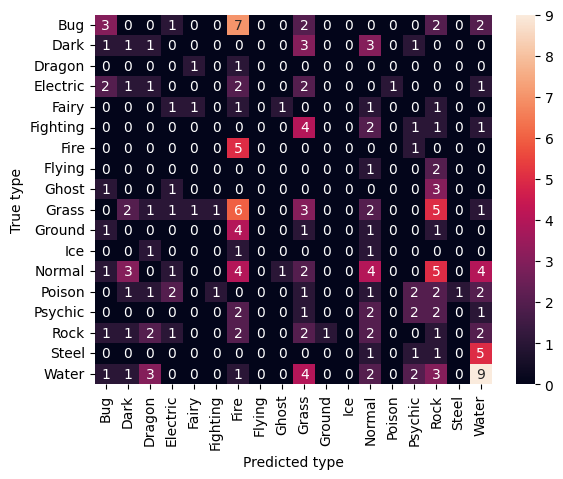

In [41]:
confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_predict, axis=1))
heatmap(confusion, annot=True, xticklabels=list(onehot_encoder.categories_[0]), yticklabels=list(onehot_encoder.categories_[0]), fmt="g")
plt.xlabel("Predicted type")
plt.ylabel("True type")
plt.show()

The confusion matrix shows that types like Water, Fire, and Normal have the most amount of correct positive predictions. However, with this large matrix, it is not immediately visible which types are most accurately predicted overall.

To check how accurately each type is classified, we can also generate a separate binary confusion matrix for each individual type. In this case, we count the 3 most likely predictions as positive labels. In other words, for a given type, a true positive outcome is if a Pokemon has that type and the CNN's top 3 predictions for the Pokemon include that type. Similarly, a true negative is if a Pokemon does not have that type and none of the CNN's top 3 predictions for the Pokemon are that type.

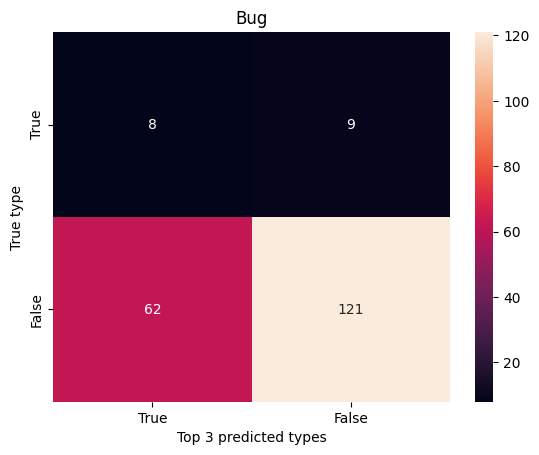

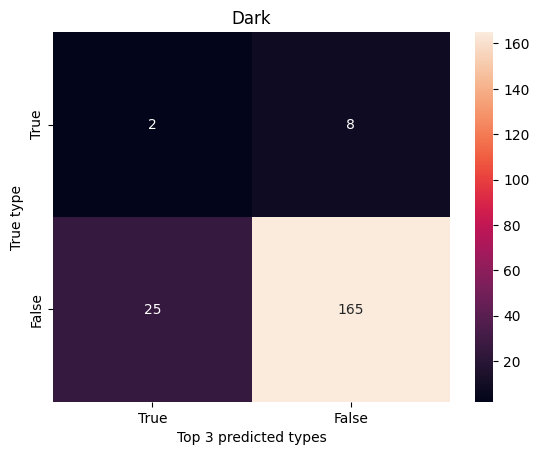

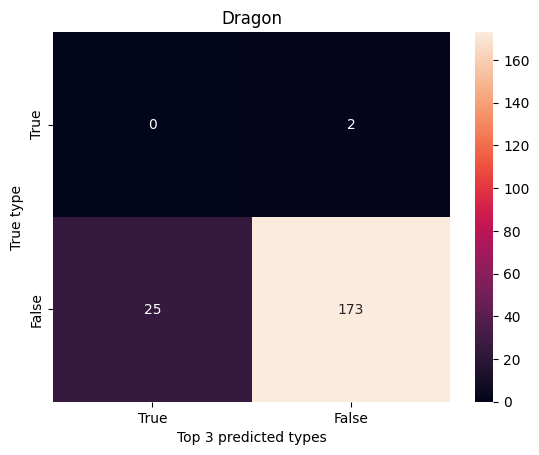

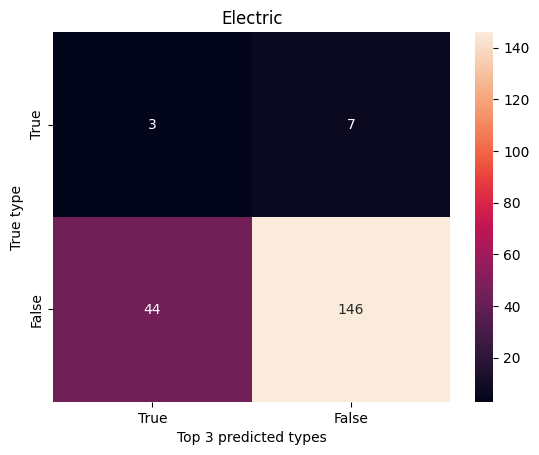

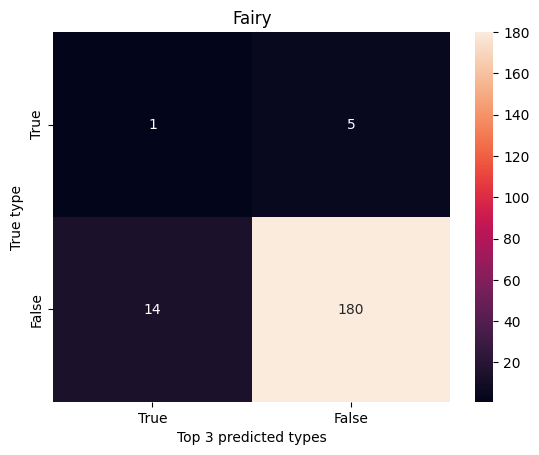

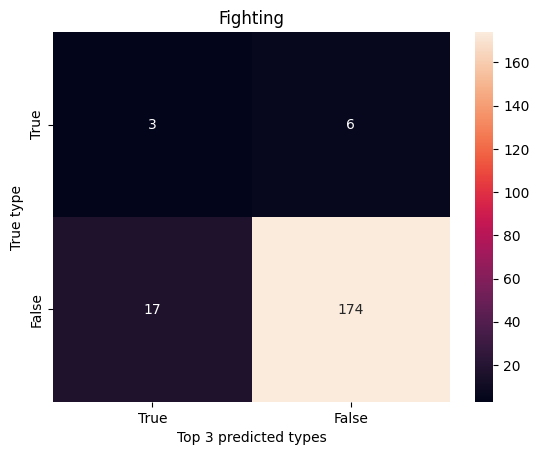

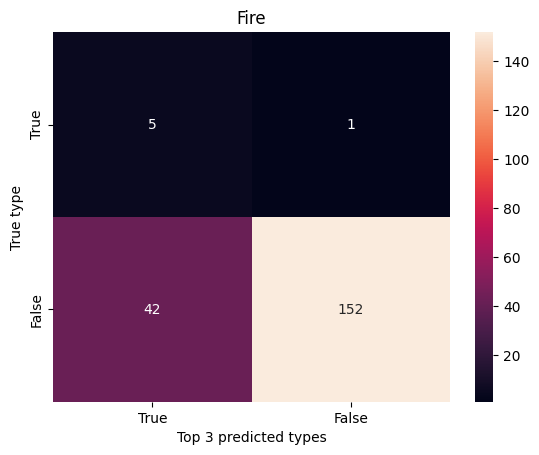

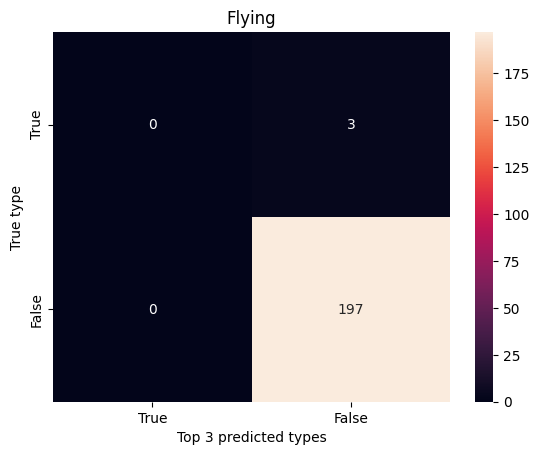

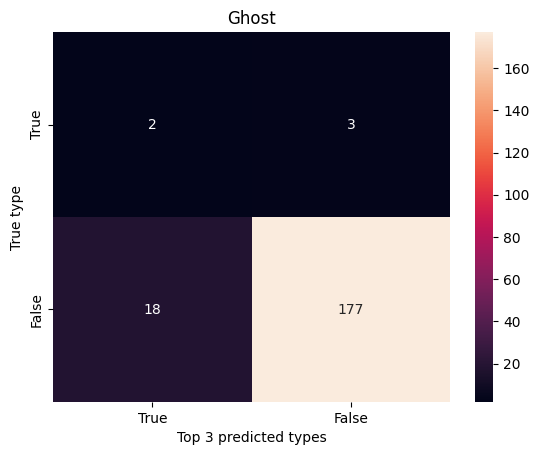

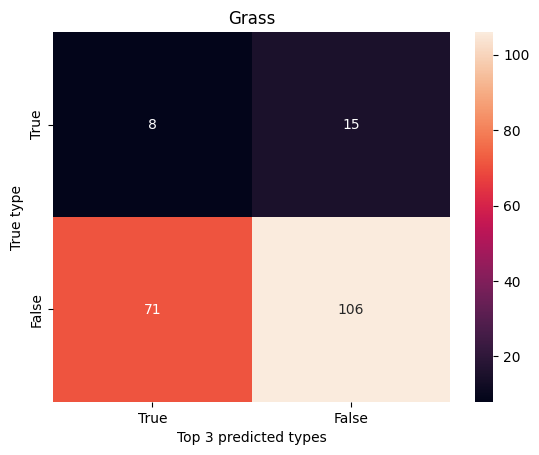

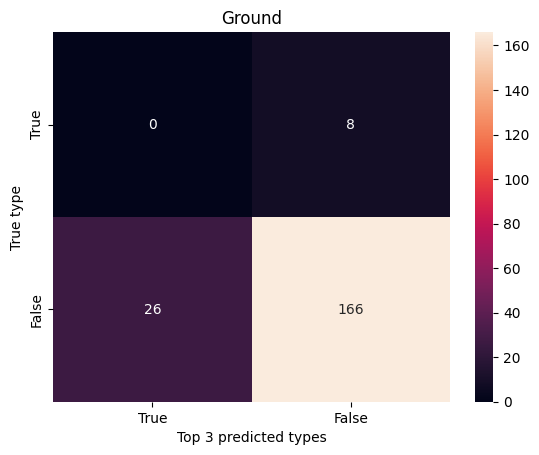

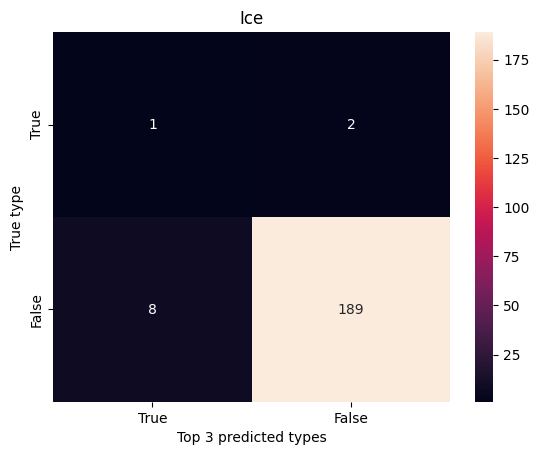

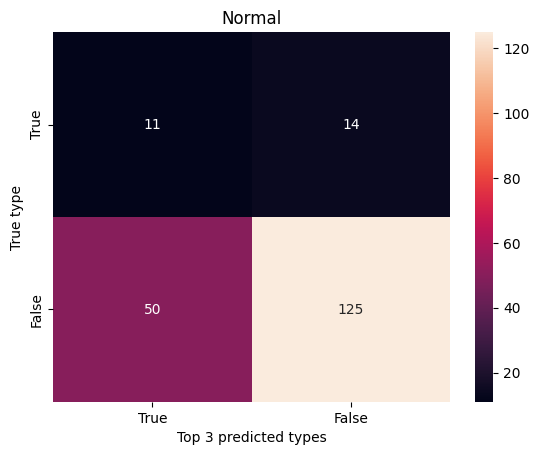

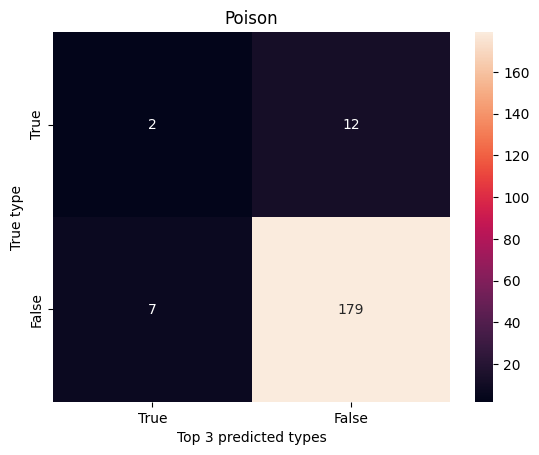

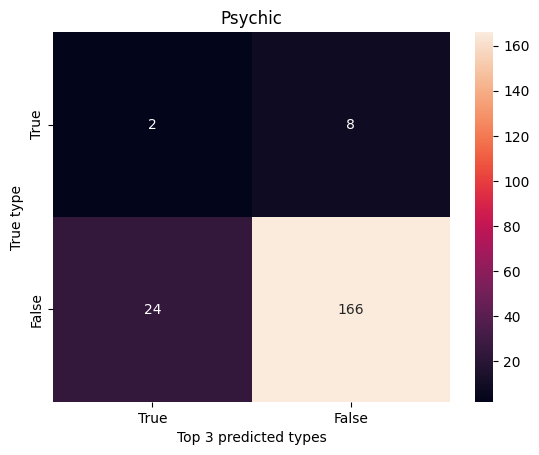

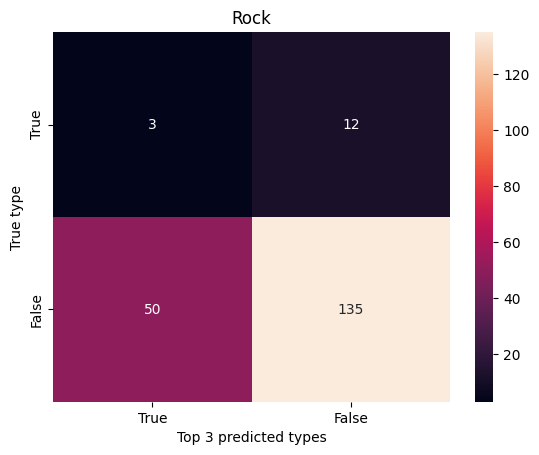

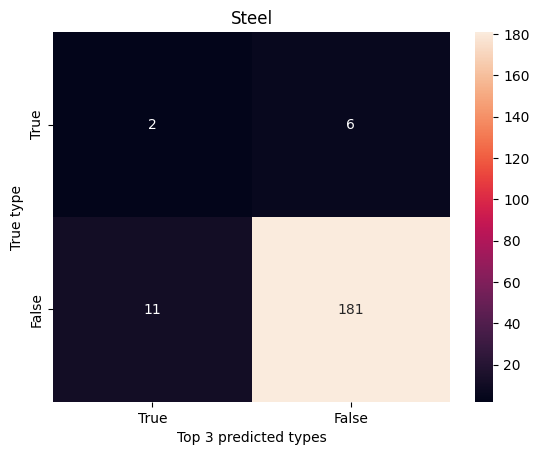

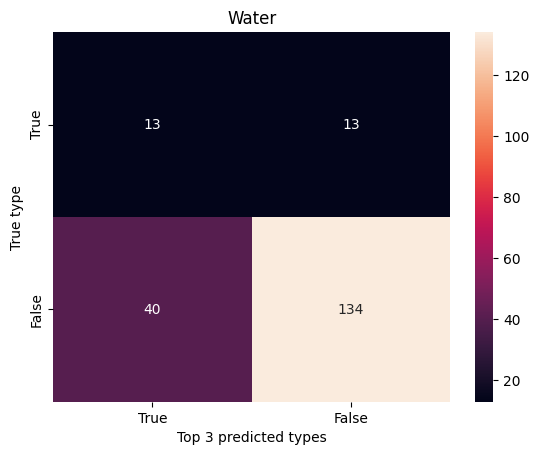

In [42]:
for i in range(len(onehot_encoder.categories_[0])):
    binary_y_test = [True if np.argmax(y) == i else False for y in y_test]
    binary_y_predict = [True if i in np.argsort(y)[-3:] else False for y in y_predict]
    confusion = confusion_matrix(y_true=binary_y_test, y_pred=binary_y_predict, labels=[True, False])
    heatmap(confusion, annot=True, xticklabels=[True, False], yticklabels=[True, False], fmt="g")
    plt.title(onehot_encoder.categories_[0][i])
    plt.xlabel("Top 3 predicted types")
    plt.ylabel("True type")
    plt.show()

Now we can see that types like Rock, Electric, and especially Fire are types that often have a high probability of prediction, even if many of the Pokemon in the test set do not actually have those types.

## Building a General Adversarial Network (GAN)

### Motivation for the GAN

Every new generation of pokemon games comes with a totally new cast of pokemon. As more games come out and more pokemon are added, designs for new pokemon may become harder to come up with over time. One way to help with inspiration is to get input from outside sources. Sometimes artists go to art galleries when they are stumped for their next piece, or writiers have trouble with writers block and need a new perspective. The resulting generator can be used as this new perspective.

### What are GANs?

GANS are composed of two models, a discriminator and a generator. The making of new pokemon is the result of the generator. And in order to train the generator, we use a discriminator. The purpose of the discriminator, is to decide whether or not an input is real, i.e. an example taken from the data's distribution. The inputs to the discriminator, are real examples, and the results from the generator. The predictions are what are used to train the GAN. If you are interested in reading more, check out this [blog post](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/).

In [8]:
IMAGE_DIR = 'data/'
image_size = 64
batch_size = 4
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

One way to address the limited data issue is to transform what data we do have by doing things like mirroring across different axes. But you can also do like shifting as well. Here we do a vertical flip.

We specifically avoid a horizontal flip because we don't want to generate images where the feet would be on its head for example.

But one way to increase data is to use different images of the same pokemon just in different art styles. There are many different ways pokemon are drawn, both by official games and by fans. Even within the games, there could be multiple versions of the images like the pokedex entry image, in battle image, etc. This would mean getting more data though.

In [9]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with mirrored images
mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Combine the datasets
dataset_list = [normal_dataset, mirror_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

### Designing the Discriminator

One of the two main models within the GAN, the discriminator takes inputs, in this case images of pokemon, and predicts whether they is real or fake. The structure of the model, what layers, how many to use, the hyperparameters for the layers can be anything as long as they match up with the one before and after. The only layer that really fixed is the last layer, the output layer. Because the output is binary: real or fake, we use sigmoid. But you are able to use other [activation functions](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6).

In [10]:
dis = nn.Sequential(
  # Input is 3 x 64 x 64
  nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.LeakyReLU(0.2, inplace=True),
  # Layer Output: 64 x 32 x 32
  
  nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2, inplace=True),
  # Layer Output: 128 x 16 x 16
  
  nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2, inplace=True),
  # Layer Output: 128 x 8 x 8
  
  nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2, inplace=True),
  # Layer Output: 128 x 4 x 4
  
  # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
  nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
  nn.Flatten(),
  nn.Sigmoid()
)

### Designing the Generator

The Generator is the other main model within the GAN and is the part of interest. It takes in random noise and ouputs images that should ideally represent some new pokemon. These outputs should trick the discriminator. Again, the structure of the model can be anything as long as they match up with each other. This is slightly more complicated becasue the output layer should result in a shape that resembles an image. Because we use 64x64x3 dimension images for actual pokemon, we will do the same for these fake pokemon.

In [11]:
seed_size = 16

gen = nn.Sequential(
  # Input seed_size x 1 x 1
  nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(True),
  # Layer output: 256 x 4 x 4
  
  nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(True),
  # Layer output: 128 x 8 x 8
  
  nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(True),
  # Layer output: 64 x 16 x 16
  
  nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(True),
  # Layer output: 32 x 32 x 32
  
  nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
  nn.Tanh()
  # Output: 3 x 64 x 64
)

### GPU Setup

Set up the GPU to utilize the parallel computing power because the CPU will take significantly more time for training.

In [12]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

Ensure the GPU is active. Below should be type CUDA for cuda cores, which are in the GPU. If the type is CPU, then you are using CPU.

In [13]:
device = get_training_device()
device

device(type='cuda')

Now, we use the device dataloader class to send data to our chosen device which should be the GPU:

In [14]:
dev_dataloader = DeviceDataLoader(dataloader, device)

## Training Functions

Training is taken in turns because we have to use the output from the models to train the other model. This article is helpful in seeing how the two models interact.

### Discriminator

The discriminator takes real pokemon and learns from them. Then takes the fake pokemon from the generator and learns from them as well. Then this output then this output will be backpropagated to update weights for each layer.

In [15]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()
    
    # Train on the real images
    real_predictions = discriminator(real_pokemon)
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0
    real_loss = F.binary_cross_entropy(real_predictions, real_targets)
    real_score = torch.mean(real_predictions).item()
    
    # Make some latent tensors to seed the generator
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
    # Get some fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Train on the generator's current efforts to trick the discriminator
    gen_predictions = discriminator(fake_pokemon)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item()
    
    # Update the discriminator weights using backpropagation
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()

    # Return discriminator loss and scores from the real data and generator data
    return total_loss.item(), real_score, gen_score

### Generator

The generator trains by generating fake pokemon and running them through the current discriminator's weights and using those to update its own weights. This is why we need to setup training to be one then the other.

In [16]:
def train_generator(gen_optimizer):
    # Clear the generator gradients
    gen_optimizer.zero_grad()
    
    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    
    # Test against the discriminator
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device)
    loss = F.binary_cross_entropy(disc_predictions, targets)
    
    # Update the generator based on how well it did against the discriminator using backpropgation
    loss.backward()
    gen_optimizer.step()
    
    # Return generator loss
    return loss.item()

Deciding how much to train one before swapping to the other and back is another problem. It could be the case that one model will converge faster. So deciding what is the optimal amount requires some empirical analysis of the model, the data itself, and other things.

### Results

So we can see the results as we generate pokemon. We will save the outputs per epoch to a folder called Results.

In [17]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'Results/'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [18]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Reverse the normilzation of images so we can see the visuals properly
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

In [20]:
def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result_image_for_epoch-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

### Run Training

This set ups the framework for training and uses all of the predefined methods above.

In [21]:
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in dev_dataloader:
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

### Selecting Models

Here, we select the models we want to send to the GPU.

In [22]:
# Set the discriminator to device
discriminator = to_device(dis, device)

# Set the generator to device
generator = to_device(gen, device)

### Training Time

Set hyperparamters and train the GAN

In [23]:
# initial hyperparameters: lr = 0.002, epochs = 50
learning_rate = 0.002
epochs = 50

In [25]:
discriminator.load_state_dict(torch.load("gan-checkpoints\\discriminator-model.pth"))
generator.load_state_dict(torch.load("gan-checkpoints\\generator-model.pth"))

<All keys matched successfully>

### Results

Here, we will view some of the results for the Pokemon GAN using IPython's Image class

This the first iteration.

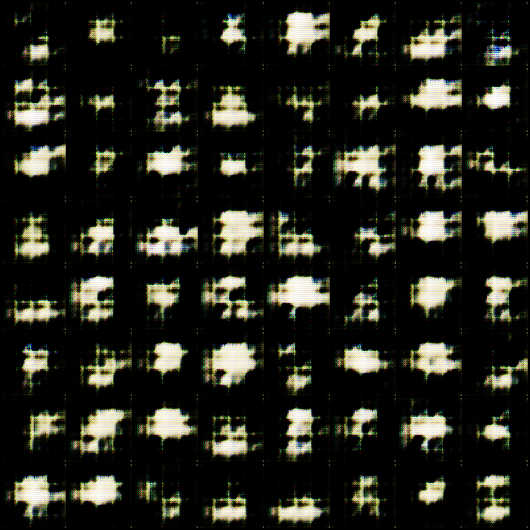

In [26]:
show_img('Results/result_image_for_epoch-0001.png')

At 25 epochs, more distinct features start appearing, like tails, legs.

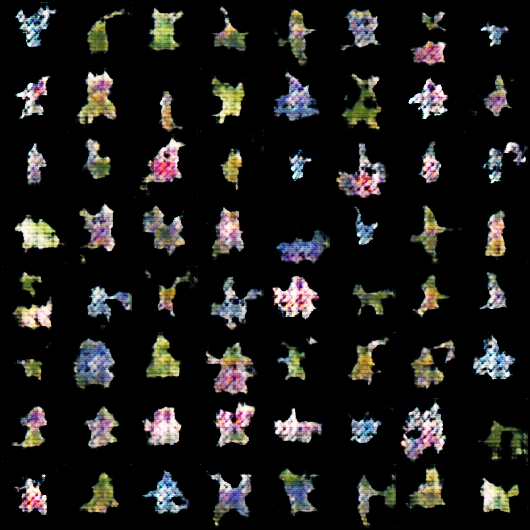

In [27]:
show_img('Results/result_image_for_epoch-0025.png')

At 50 epochs, this is the final result.

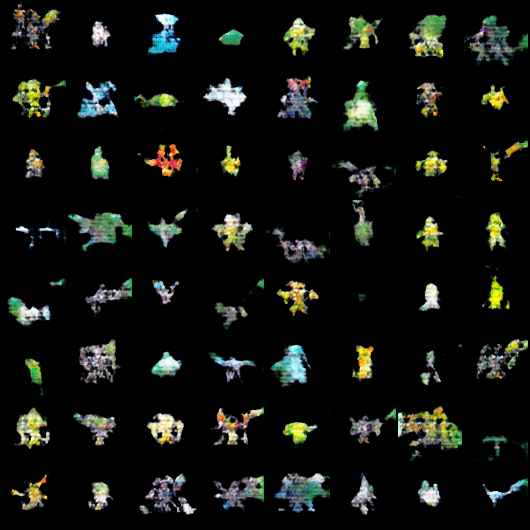

In [28]:
show_img('Results/result_image_for_epoch-0050.png')

### Performance Analysis

Here are some plots to help tune the generator/discriminator. This shows losses and scores over time.

In [ ]:
# Extract metrics
disc_losses, disc_scores, gen_losses, gen_scores = history

In [ ]:
# Plot generator and discriminator losses
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

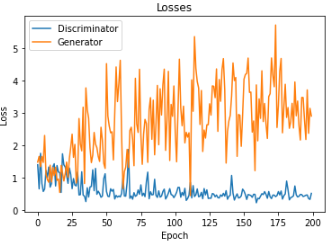

The graph above is from a previous run of our GAN with the same data set. The results of the model show that the discriminator had lower loss throughout training and has a general trend of lowering as each epoch past. While the generator has a much higher loss that does not really taper off. This could signal that the data generated isn't that good which makes sense if you look at the image results, they don't really resemble pokemon. The only resemblance is the shape, you can see some key features in some like legs, tails, etc., which are found in pokemon, but the finer details are missing, for example, eyes, mouths, fingers. And the key characteristic is the distinct colors which is missing. Pokemon typically have solid colors with distinct seperation. But the outputs are a kind of gradient of colors, there is no solid color next to each other.

### Saving Model Weights

Checkpoint the weights to be further trained and examined.

In [ ]:
# Save generator and discriminator weights
torch.save(discriminator.state_dict(), 'discriminator-model.pth')
torch.save(generator.state_dict(), 'generator-model.pth')

## Conclusions

Overall, we learned that our models still have a decent way to go before they can be capable of reliably classifying our examples. We learned that there is a lot of context behind classifying Pokemon that make it difficult for a Machine Learning algorithm to learn from it. For example, we know that Grass-type Pokemon look plant-like, and we have examples of plants in our heads that we can compare the Pokemon to that the model doesn't.

As for our GAN, it was able to learn the general shape of the Pokemon, but the colors were more abstract and didn't output solid colors as are usually found in Pokemon. Both of our models had a severe lack of data, something that is incredibly important when training image recognition models like these. With us being limited by there only being 1008 Pokemon, our models were unable to fully learn patterns, but we could definitely see the beginning of a pattern being learned. It would be interesting going forward to experiment with using the GAN output as an input to our CNN, and what would happen if more data was added to the mix.